## Проверка статистических гипотез с помощью бутстрап

Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва.<br>
В полученных подвыборках считаются статистики (среднее, медиана и т.п.).<br>
Из статистик можно получить ее распределение и взять доверительный интервал.<br>
ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрап это может сделать.

In [1]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузим данные
df = pd.read_csv('hw_bootstrap.csv', sep=';')
print(f'Shape - {df.shape}')
df.head()

Shape - (1000, 3)


,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [3]:
# Посмотрим на типы данных
df.dtypes

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [4]:
# Приведем столбец value к числовому значению
df['value'] = df.value.str.replace(',', '.').astype('float')
df.head()

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control


In [5]:
# Посмотрим на уникальные значения experimentVariant
df.experimentVariant.unique()

array(['Control', 'Treatment'], dtype=object)

In [6]:
# Создадим переменные с значениями по двум группам
treatment = df[df['experimentVariant'] == 'Treatment'].value
control = df[df['experimentVariant'] == 'Control'].value

In [7]:
# Посмотрим на описательную статистику по переменной control
control.describe(percentiles=[0, 1/6, 1/3, .5, 2/3, 5/6, 1]).to_frame().T

,count,mean,std,min,0%,16.7%,33.3%,50%,66.7%,83.3%,100%,max
value,500.0,10.026867,0.979377,6.436541,6.436541,9.056784,9.659439,10.018465,10.374155,10.91406,13.130346,13.130346


In [8]:
# Посмотрим на описательную статистику по переменной tretment
treatment.describe(percentiles=[0, 1/6, 1/3, .5, 2/3, 5/6, 1]).to_frame().T

,count,mean,std,min,0%,16.7%,33.3%,50%,66.7%,83.3%,100%,max
value,500.0,27.321499,186.557011,6.436541,6.436541,9.05836,9.660412,10.025847,10.380102,10.929937,3000.0,3000.0


**Из описательной статистики видно, что 83% наблюдений в группе tretment не превышают значения 10,93. При этом максимальное значение равно 3000 что свидетельствует о возможных выбросах в исследуемых данных.**

In [9]:
# посмотрим на возможные выбросы
treatment[treatment > 14]

995    1000.0
996    1200.0
997    1500.0
998    2000.0
999    3000.0
Name: value, dtype: float64

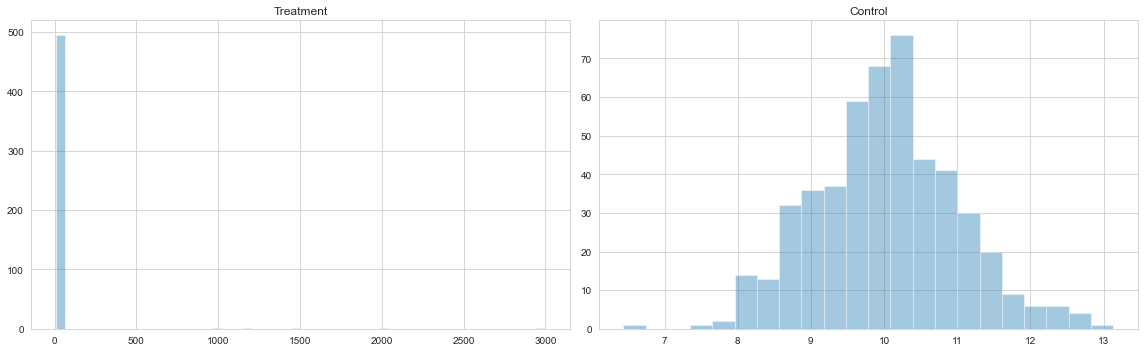

In [10]:
# Посмотрим на распределения
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 5))

for ax, col, title in zip(axes.flatten(), [treatment, control], ['Treatment', 'Control']):
    sns.distplot(col, kde=False, ax=ax)
    ax.set(xlabel='')
    ax.set(title=title)

    
plt.tight_layout();

Из распределений видно, что из-за наличия сильных выбросов в группе ```treatment``` это распределение получается ассиметричным.
Распределение наблюдений в группе ```control``` близко к нормальному распределению.

In [11]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.figure(figsize=(10, 6))
    sns.histplot(pd.Series(pd_boot_data[0]))
    sns.despine()
    plt.vlines(ci, ymin=0, ymax=100, linestyle='--', colors='r')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show();
       
    return {'boot_data': boot_data, 
            'ci': ci, 
            'p_value': p_value}

<hr>

# Сравнение средних значений


### Сформулируем гипотезы для проверки:


- **Нулевая гипотеза** $(H_0)$: Средние значения в группах ```treatment``` и ```control``` НЕ различаются
- **Альтернативная гипотеза** $(H_1)$: Разница между средними значениями в группах ```treatment``` и ```control``` есть

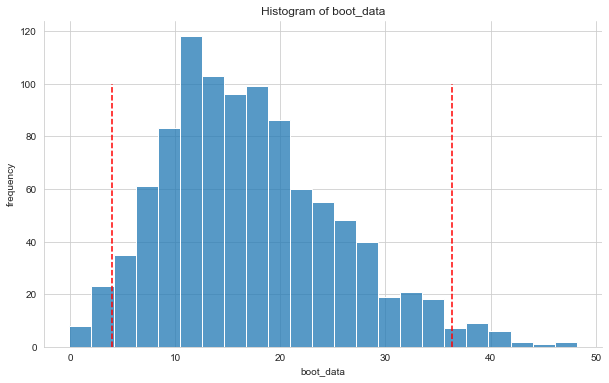

In [12]:
# Применим бутстрап и рассчитаем 95% дов. интервал для средних значений
booted_mean = get_bootstrap(treatment, control)

In [13]:
# Выведем значения 95% дов. интервала для средних
booted_mean["ci"]

,0
0.025,3.948821
0.975,36.309560


In [14]:
# Посмотрим на значение p-value
print(f'Bootstrap p-value: {booted_mean["p_value"].round(3)}')

Bootstrap p-value: 0.038


In [15]:
# Посмотрим на значение p-value критерия Манна-Уитни
print(f'Mann-Whitney p-value: {mannwhitneyu(treatment, control)[1].round(3)}')

Mann-Whitney p-value: 0.859


**Таким образом, сравнение средних значений в двух группах с помощью бутстрап позволяет сделать вывод о том что различие статистически значимо ($p < 0.05$), т.е. позволяет отклонить нулевую гипотезу о равенстве средних значений. При этом значение p-value критерия Манна-Уитни $p > 0.05$ говорит о том, что различие средних ранговых значений в двух группах статистически НЕ значимо.**

<br>

# Сравнение медианных значений


### Сформулируем гипотезы для проверки:


- **Нулевая гипотеза** $(H_0)$: Медианные значения в группах ```treatment``` и ```control``` НЕ различаются
- **Альтернативная гипотеза** $(H_1)$: Разница между медианными значениями в группах ```treatment``` и ```control``` есть

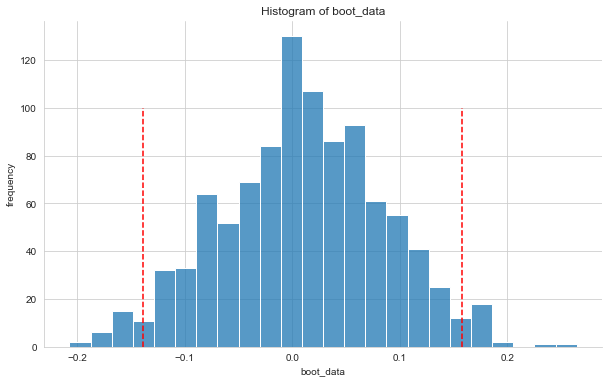

In [16]:
# Применим бутстрап и рассчитаем 95% дов. интервал для медианных значений
booted_median = get_bootstrap(treatment, control, statistic = np.median)

In [17]:
# Выведем значения 95% дов. интервала для медианных значений
booted_median["ci"]

,0
0.025,-0.138616
0.975,0.157814


In [18]:
# Посмотрим на значение p-value
print(f'Bootstrap p-value: {booted_median["p_value"].round(3)}')

Bootstrap p-value: 0.895


In [19]:
# Посмотрим на значение p-value критерия Манна-Уитни
print(f'Mann-Whitney p-value: {mannwhitneyu(treatment, control)[1].round(3)}')

Mann-Whitney p-value: 0.859


**Таким образом, сравнение медианных значений в двух группах с помощью бутстрап позволяет сделать вывод о том что различие статистически НЕ значимо ( $p > 0.05$), т.е. НЕТ оснований для отклонения нулевой  гипотезы о равенстве медианных значений. При этом значение p-value критерия Манна-Уитни $p > 0.05$ говорит о том, что различие средних ранговых значений в двух группах статистически НЕ значимо.**

<br>

**На основании проведенного исследования можно сделать следующие выводы:**
- **применение критерия Манна-Уитни показывает, что статистически значимого различия между сравниваемыми группами нет;**
- **применение бутстрап для сравнения средних значений двух групп показывает статистически значимые различия. Так как бутстрап и критерий Манна-Уитни показывают противоречивые результаты при сравнении средних значений, в рассматриваемом примере предпочтительнее положится на критерий Манна-Уитни, который более устойчив к выбросам в данных (в группе ```treatment``` имеются возможные очень сильные выбросы, которые смещают оценку среднего значения. Требуется дополнительный анализ чтобы понять чем обусловлены эти выбросы);**
- **применение бутстрап для сравнения медианных значений двух групп показывает статистически НЕ значимые различия.**